## Recruit Restaurant Visitor Forecasting
Forecast restaurant visits for establishments in Japan based on historical visits and reservation data from two websites - Hot Pepper Gourmet and AirREGI. We are also given some additional metadata on the restaurants such as genre and location. Find the competition on [this link at kaggle](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)



In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%html
    <style>.container { width:90% !important;} </style>

### Read the data

NB: The number of stores with reservations = number of reservations because there's one reservation per store.
    For this reason the mean is IMO a good normalized measure of visits, mean = # visits / # reserved stores

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import calendar
# 
air = pd.read_csv('../input/air_visit_data.csv', parse_dates=[1])
air.set_index(['visit_date'], inplace=True)
air.index.name=None
air.drop('air_store_id',axis=1,inplace=True)
df2=pd.DataFrame()
df2['visit_total'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].sum()
df2['visit_mean'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].mean()
df2['reserv_cnt'] = air.groupby(air.index,squeeze=True,sort=True)['visitors'].count()
air=df2;del df2

#Get the date info with dow and holidays
hol=pd.read_csv('../input/date_info.csv', parse_dates=True).rename(columns={'calendar_date':'visit_date'})
hol['visit_date'] = pd.to_datetime(hol['visit_date'])
hol.set_index(['visit_date'], inplace=True)
hol.index.name=None
hol.day_of_week = hol.day_of_week.apply(list(calendar.day_name).index)

#Get the test submission
test = pd.read_csv('../input/sample_submission.csv')
test['store_id'], test['visit_date'] = test['id'].str[:20], test['id'].str[21:]
test.set_index('visit_date', drop=True, inplace=True)
test.index.name=None

/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/qda.py:4: DeprecationWarning: qda.QDA has been moved to discriminant_analysis.QuadraticDiscriminantAnalysis in 0.17 and will be removed in 0.19.
  "in 0.17 and will be removed in 0.19.", DeprecationWarning)


### Explorative analysis on cumulative visits
I create a series with cumulative visits, that is the sum of visits to all stores/restaurants. Notice the huge increase in July 2016 (see above). The drop comes because many restaurants did not have any data before that month. Probably the registration system started "monitoring" many new restaurants/stores in that period.  
There is also a drop in visits and reservation counts in the beginning of the years, probably due to stores being close around new year's eve.  

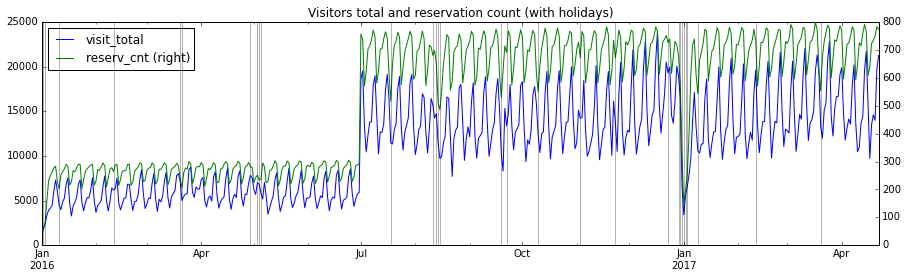

In [27]:
#Plot the cumulative visits
air['visit_total'].plot(legend=True);
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True,
                      title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

Instead of the sum of visits, a better measurement is **the mean** of the cumulative visits (sum of all visits divided by number of reservations or, which is the same, the number of "active" restaurants). The series does not show the gap in July 2016 anymore, though variance seems to become smaller for some months.

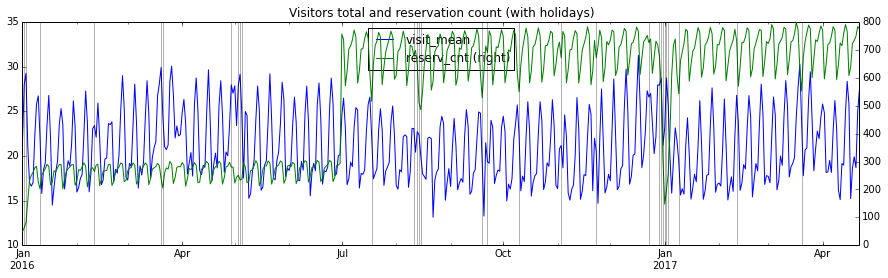

In [28]:
air['visit_mean'].plot(figsize=(15,4), legend=True, title='Visitors mean (with holidays)')
air['reserv_cnt'].plot(legend=True, figsize=(15,4), secondary_y=True, title='Visitors total and reservation count (with holidays)');
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);

Applying a seasonal decomposition using moving averages. The trend captures three peaks in the data: 

* Around mid-March 2016, 
* April 2016
* Just before the drop on new year's eve 2016, 
* Again mid-March 2017 
I see on wikipedia that these are the vernal equinox (around March 20), the golden week starting on April 29, Emperor's birthday :( on December 23rd and new year's day on January 1st, vernal equinox again.  
This sounds great, though some other holidays are hardly visible in the data. I can imagine that people has the tendency to stay home in the winter.

The season plot shows a strong weekly period where the lowest number of visit happen on Monday. Below I show that people mostly do reservations between Friday and Sunday.

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


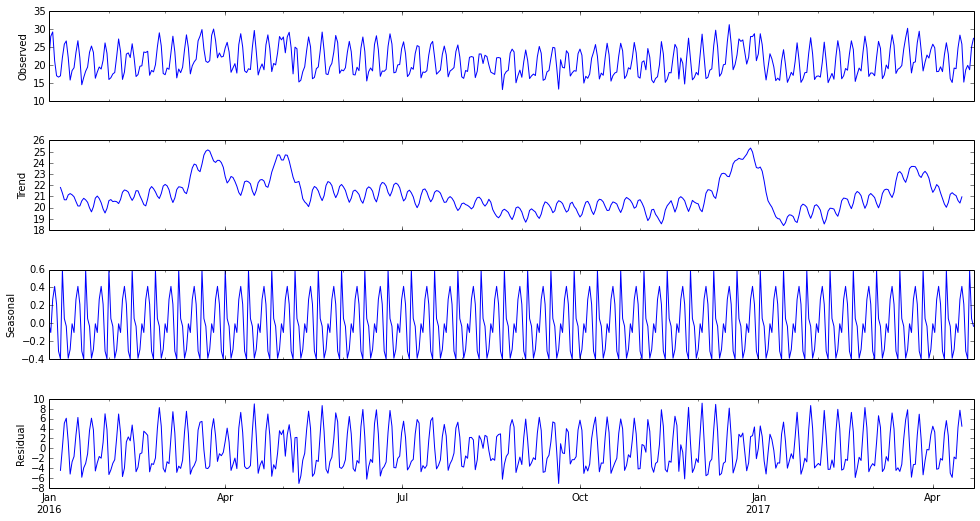

In [6]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(air.visit_mean, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [7]:
df2=air.join(hol)
df2[df2.holiday_flg==0].groupby(hol.day_of_week,squeeze=True,sort=True)['visit_mean'].sum()
#df2.day_of_week=df3.day_of_week.apply(lambda x: list(calendar.day_name)[x]) # equiv to air.sum(0)

day_of_week
0     990.358277
1    1166.228003
2    1265.651637
3    1162.836395
4    1503.191793
5    1731.514759
6    1534.474447
Name: visit_mean, dtype: float64

### Pre-ARIMA analysis: make the series stationary
Stationary means that variance and autocorrelation structure not changing over time.  
Changes in mean happen when the series has a overall trend, e.g. it increases/decreasing. In that case use differentiation: create a new series y with the first difference y=x$_t$-x<sub>t-1</sub> (this is the "I" in ARIMA models), and take seasonal differences (which you can account for in ARIMA model).  
Changes is variance mean that oscillations change. To fix this a log of the series compresses oscillations.  
Changes in autocorrelation means that oscillations become broader (or narrower). If you have this I think you are screwed..

The Dickey-Fuller test helps us deciding whether a series is stationary. The test's null hypothesis is that the series is non-stationary. If the Test Statistic output of the Dickey-Fuller test is less than the Critical Value, we can reject the null hypothesis and say that the series is stationary.  
Below we notice that the original time series (using the mean of visits) is fairly stationary: Test Statistic=-3.796104 > Critical Value (1%) = -3.444615. Applying 1st or seasonal differentiation greatly improves the test results (Test Statistic = -6.608968 and 7.196314, respectively). A weekly periodic structure is clearly visible in the data, so I lean towards using seasonal differentiation. 
Takign the log of the data helps but does not seem to be a main factor in improving stationarity. This means that variance is fairly stable. 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


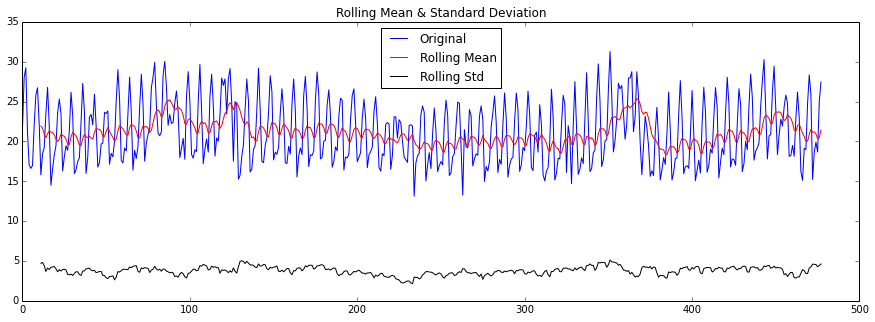

Results of Dickey-Fuller Test:
Test Statistic                  -3.796104
p-value                          0.002947
#Lags Used                      16.000000
Number of Observations Used    461.000000
Critical Value (5%)             -2.867830
Critical Value (1%)             -3.444615
Critical Value (10%)            -2.570120
dtype: float64


'test_stationarity(air.visit_mean_log) #-3.830754'

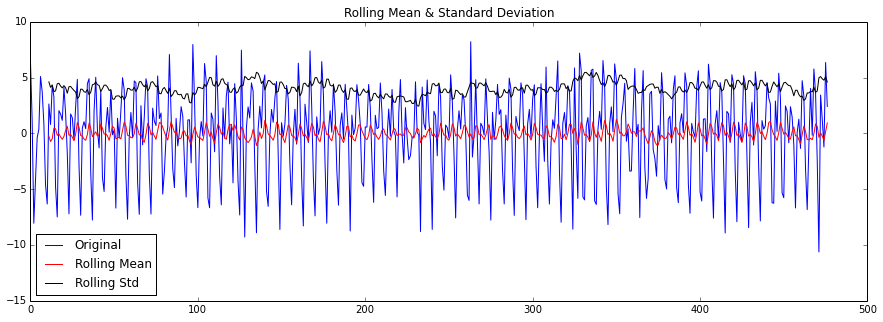

Results of Dickey-Fuller Test:
Test Statistic                -6.608968e+00
p-value                        6.448883e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.580000e+02
Critical Value (5%)           -2.867871e+00
Critical Value (1%)           -3.444709e+00
Critical Value (10%)          -2.570142e+00
dtype: float64


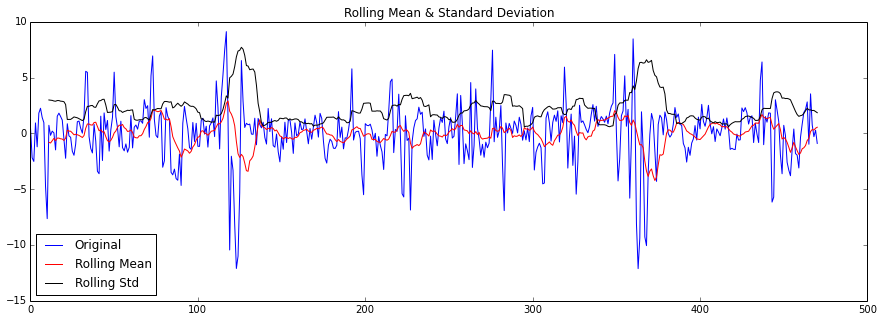

Results of Dickey-Fuller Test:
Test Statistic                -7.196314e+00
p-value                        2.429479e-10
#Lags Used                     1.500000e+01
Number of Observations Used    4.550000e+02
Critical Value (5%)           -2.867913e+00
Critical Value (1%)           -3.444804e+00
Critical Value (10%)          -2.570165e+00
dtype: float64


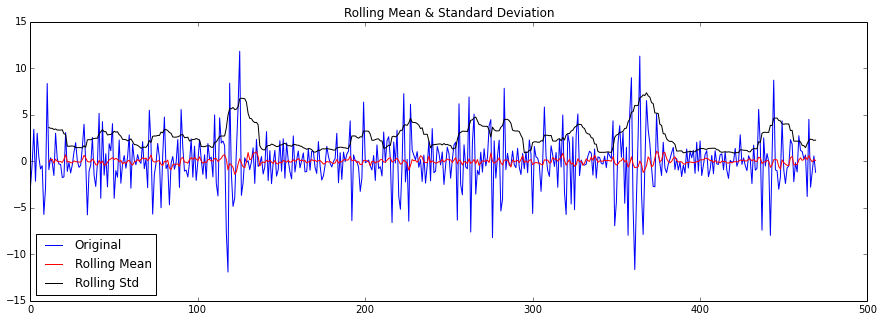

Results of Dickey-Fuller Test:
Test Statistic                -9.427797e+00
p-value                        5.288819e-16
#Lags Used                     1.600000e+01
Number of Observations Used    4.530000e+02
Critical Value (5%)           -2.867941e+00
Critical Value (1%)           -3.444868e+00
Critical Value (10%)          -2.570180e+00
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12);
    rolstd = pd.rolling_std(timeseries, window=12);

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

test_stationarity(air.visit_mean); #-3.796104
# Log is a minor improvement, meaning that the variance is stable
air.visit_mean_log= air.visit_mean.apply(lambda x: np.log(x))  
'''test_stationarity(air.visit_mean_log) #-3.830754'''
# Although I see no real global trend, 1st difference strongly improves stationarity
air['visit_mean_diff'] = air.visit_mean - air.visit_mean.shift(1)  
test_stationarity(air.visit_mean_diff.dropna(inplace=False)) #-6.608968e+00
# Seasonal difference: take a weekly season improves stationarity even more
air['visit_mean_seasonal'] = air.visit_mean - air.visit_mean.shift(7)
test_stationarity(air.visit_mean_seasonal.dropna(inplace=False)) #-7.196314e+00
# Seasonal and 1st difference is even better, but we were already well within the 1% confidence interval
air['visit_mean_seasonal_diff'] = air.visit_mean_diff - air.visit_mean_diff.shift(7)
test_stationarity(air.visit_mean_seasonal_diff.dropna(inplace=False)) #-9.427797e+00

mmm, let's stick to the seasonal series with **no 1st difference**. 

Let's run autocorrelation ACF and partial autocorrelation PACF for find the details fo the model. I will use the guidelines [here](http://people.duke.edu/~rnau/arimrule.htm).

The following ACF on the mean visits has a repeated pattern. That's our 7-day seasonal term. I should add to the model seasonal differenciation in the term **seasonal\_order=( , 1, ,7)**.  
If ACF was positive and decreasing over time, the series would be the typical candidate for applying 1st difference. But not here. This confirms the observation we made on the Dickey-Fuller test where the 1st difference was more stationary but not that much. I should add a **order=( , 0, ) term** to the model. Also try a constant term **trend='c'** in the model for the non-zero mean value.

ACF and PACF of the visit mean:


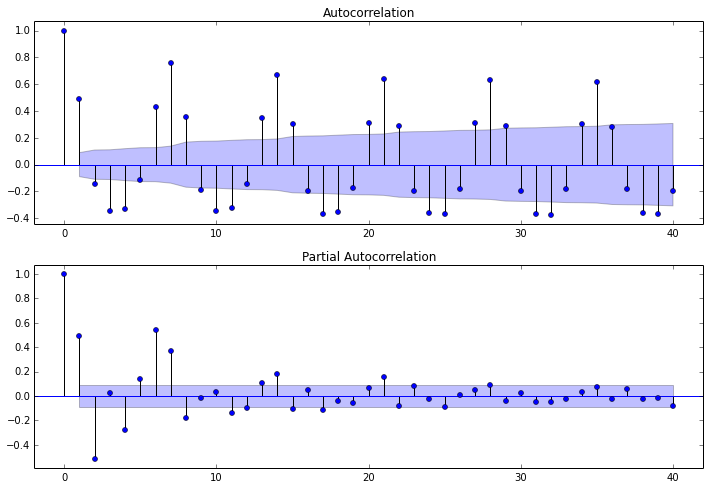

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean, lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(air.visit_mean, lags=40, alpha=.05, ax=ax2)
print "ACF and PACF of the visit mean:"

This is the ACF of the first difference, confriming the 7-day seasonal term. 

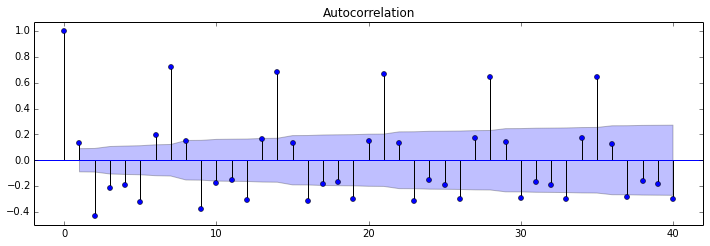

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean_diff[1:], lags=40, alpha=.05, ax=ax1)

The ACF and PACF below are plotted the seasonal difference data.

The PACF of the seasonal differenced series is positive at lag=1 (the series appears slightly "underdifferenced"). I should probably add one AR term to the model **order=(2, , )**. Only one AR term because the term at lag=2 cuts off and enters the 95% confidence interval. 

As for the PACF, the ACF of the seasonal differenced series is overdifferentiated at lag = 1 and cuts off (which I looked on the internet and means "go to zero") at lag=2. I should probably add one MA term to the model **order=( , , 2)**.

displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model.


The ACF of the differenced series is negative at lag 7, suggesting to add a seasonal MA term **seasonal\_order=(0, , 1, 7)** to the model. This situation is likely to occur if a seasonal difference has been used, which should be done if the data has a stable and logical seasonal pattern. If the peak was positive I would have added a season AR term. 



ACF and PACF of the 7-day differenced visit mean:


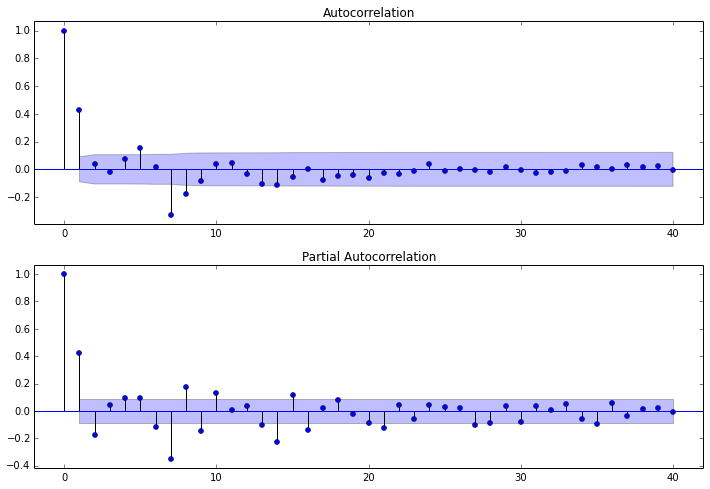

In [11]:
print "ACF and PACF of the 7-day differenced visit mean:"
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(air.visit_mean_seasonal[8:], lags=40, alpha=.05, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(air.visit_mean_seasonal[8:], lags=40, alpha=.05, ax=ax2)

More things to keep in mind:  
Rule 9: If there is a unit root in the AR part of the model--i.e., if the sum of the AR coefficients is almost exactly 1--you should reduce the number of AR terms by one and increase the order of differencing by one.  
Rule 10: If there is a unit root in the MA part of the model--i.e., if the sum of the MA coefficients is almost exactly 1--you should reduce the number of MA terms by one and reduce the order of differencing by one.  
Rule 11: If the long-term forecasts* appear erratic or unstable, there may be a unit root in the AR or MA coefficients.

### SARIMAX model 
[SARIMAX](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) = Seasonal Auto Regressive Integrated Moving Average with eXogenous variables

In [12]:
#sklearn.metrics .mean_squared_log_error should exist but I cannot load it..
from sklearn.metrics import mean_squared_error
def mean_squared_log_error(y_pred, y_true, **dict):
    '''Assume y_true is NaN free and y_pred can have consecutive NaN in the beginning of the series'''
    indfirst=y_pred.first_valid_index()
    return mean_squared_error(np.log(y_true[indfirst:]+1), 
                              np.log(y_pred[indfirst:]+1) )**0.5

                                 Statespace Model Results                                
Dep. Variable:                        visit_mean   No. Observations:                  478
Model:             SARIMAX(2, 0, 2)x(0, 1, 1, 7)   Log Likelihood                -960.180
Date:                           Wed, 06 Dec 2017   AIC                           1934.360
Time:                                   07:26:52   BIC                           1963.548
Sample:                               01-01-2016   HQIC                          1945.835
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.001     -0.428      0.669      -0.002       0.002
ar.L1          0.9745      0.113      8.608

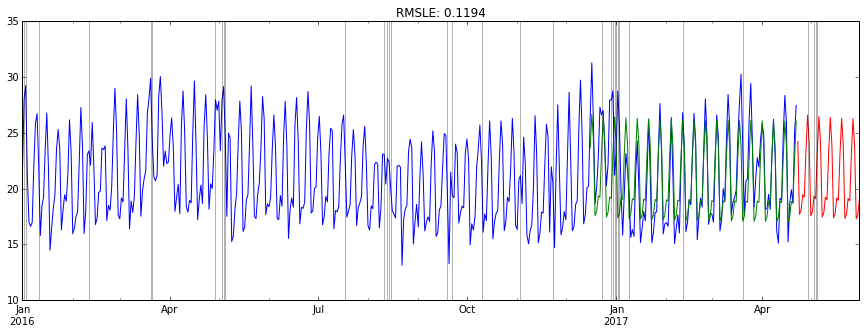

In [29]:
mod = sm.tsa.statespace.SARIMAX(air.visit_mean, trend='c', order=(2,0,2), seasonal_order=(0,1,1,7))
results = mod.fit()
print results.summary()
#Predict on future data and on time periods already known for visual inspection
pred = results.predict(start=478, end=516)
checking = results.predict(start=350, end=None, dynamic=True)
#Plot
air['visit_mean'].plot(figsize=(15, 5));
checking.plot()
pred.plot()
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);
plt.title('RMSLE: %.4f'% mean_squared_log_error(checking, air.visit_mean[350:]) );

Adding 1st order differentiation does not work (you get nan coefficients, not shown)

### SARIMAX with eXogenous dataset

Using holidays as exogenous data is already much better, it captures the peak on new year's eve

/usr/local/lib/python2.7/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                        visit_mean   No. Observations:                  478
Model:             SARIMAX(2, 0, 0)x(0, 1, 1, 7)   Log Likelihood                -936.379
Date:                           Wed, 06 Dec 2017   AIC                           1884.757
Time:                                   07:22:50   BIC                           1909.775
Sample:                               01-01-2016   HQIC                          1894.593
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0046      0.004     -1.016      0.310      -0.013       0.004
holiday_flg     3.1281      0.236     13

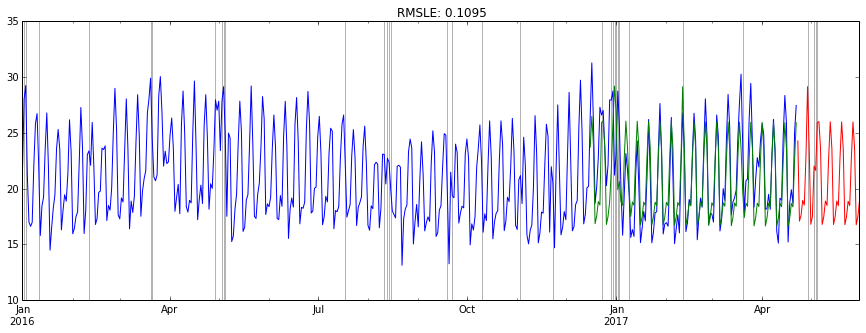

In [14]:
modx = sm.tsa.statespace.SARIMAX(air.visit_mean, trend='c', exog=hol.holiday_flg[:478], order=(2,0,0), seasonal_order=(0,1,1,7))
resultsx = modx.fit()
print resultsx.summary()
#Predict on future data and on time periods already known for visual inspection
predx = resultsx.predict(start=478, end=516, exog=pd.DataFrame(hol.holiday_flg[478:]))
checkingx = resultsx.predict(start=350, end=None, dynamic=True, exog=pd.DataFrame(hol.holiday_flg[:]) )
#Plot
air['visit_mean'].plot(figsize=(15, 5));
checkingx.plot()
predx.plot()
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);
plt.title('RMSLE: %.4f'% mean_squared_log_error(checkingx, air.visit_mean[350:]) );

Adding the day of the week column as exogenous regressors does not change the results so much. Maybe that is because we already have a season of 7 days

                                 Statespace Model Results                                
Dep. Variable:                        visit_mean   No. Observations:                  478
Model:             SARIMAX(2, 0, 0)x(0, 1, 1, 7)   Log Likelihood                -936.379
Date:                           Wed, 06 Dec 2017   AIC                           1886.757
Time:                                   07:22:54   BIC                           1915.945
Sample:                               01-01-2016   HQIC                          1898.232
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0046      0.005     -0.983      0.325      -0.014       0.005
day_of_week     0.0002   5.01e+04   3.77

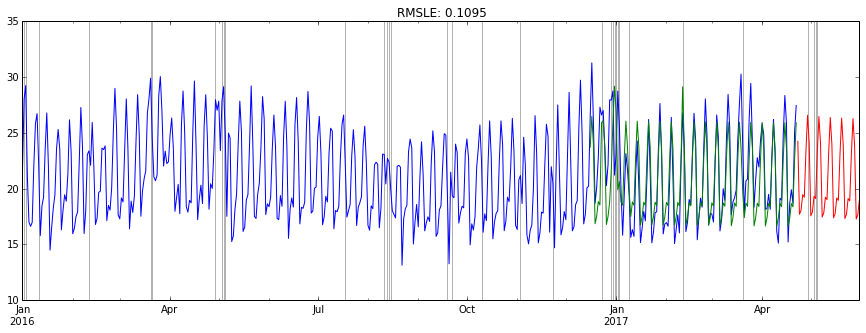

In [15]:
modx2 = sm.tsa.statespace.SARIMAX(air.visit_mean, trend='c', exog=hol[:478], order=(2,0,0), seasonal_order=(0,1,1,7))
resultsx2 = modx2.fit()
print resultsx2.summary()
#Predict on future data and on time periods already known for visual inspection
predx2 = resultsx2.predict(start=478, end=516, exog=hol[478:])
checkingx2 = resultsx2.predict(start=350, end=None, dynamic=True, exog=pd.DataFrame(hol[:]) )
#Plot
air['visit_mean'].plot(figsize=(15, 5));
checkingx2.plot()
pred.plot()
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);
plt.title('RMSLE: %.4f'% mean_squared_log_error(checkingx2, air.visit_mean[350:]) );

                                 Statespace Model Results                                
Dep. Variable:                        visit_mean   No. Observations:                  478
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 7)   Log Likelihood                -964.351
Date:                           Wed, 06 Dec 2017   AIC                           1942.702
Time:                                   07:22:58   BIC                           1971.889
Sample:                               01-01-2016   HQIC                          1954.177
                                    - 04-22-2017                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -0.0005      0.004     -0.102      0.919      -0.009       0.008
day_of_week  7.612e-05    7.6e+04      1

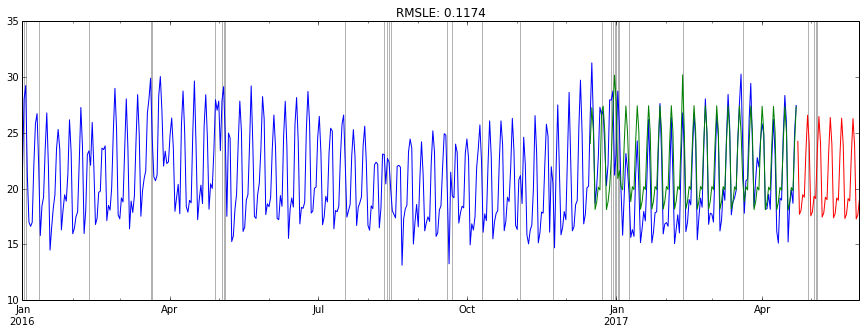

In [16]:
modx2 = sm.tsa.statespace.SARIMAX(air.visit_mean, trend='c', exog=hol[:478], order=(2,1,0), seasonal_order=(0,1,1,7))
resultsx2 = modx2.fit()
print resultsx2.summary()
#Predict on future data and on time periods already known for visual inspection
predx2 = resultsx2.predict(start=478, end=516, exog=hol[478:])
checkingx2 = resultsx2.predict(start=350, end=None, dynamic=True, exog=pd.DataFrame(hol[:]) )
#Plot
air['visit_mean'].plot(figsize=(15, 5));
checkingx2.plot()
pred.plot()
for x in hol.query('holiday_flg==1').index:
    _ = plt.axvline(x=x, color='k', alpha = 0.3);
plt.title('RMSLE: %.4f'% mean_squared_log_error(checkingx2, air.visit_mean[350:]) );

### Todo 
* Understand Ljung-Box test: which one is the critical value? Prob(Q)=0.00 sounds bad..
* Try more models
* Repeat the analysis after aggregating restaurants by regions and cuisine. Will the best models differ?

In [37]:
air.head()
full.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,cluster
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0


In [30]:
air = pd.read_csv('../input/air_reserve.csv')
airstore = pd.read_csv('../input/air_store_info.csv')
hpg = pd.read_csv('../input/hpg_reserve.csv')
hpgstore = pd.read_csv('../input/hpg_store_info.csv')

air = pd.merge(air,airstore,on='air_store_id')
hpg = pd.merge(hpg,hpgstore,on='hpg_store_id')
rel = pd.read_csv('../input/store_id_relation.csv')
airrel = pd.merge(air,rel,how='left',on='air_store_id')
hpgrel = pd.merge(hpg,rel,how='left',on='hpg_store_id')
full = pd.merge(airrel,hpgrel,how='outer')
print("there are ",len(air)," restaurants with AIR and ",len(hpg)," with HPG.",len(rel),' have both.')

('there are ', 92378, ' restaurants with AIR and ', 871308, ' with HPG.', 150, ' have both.')


In [33]:
full.head(30)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
5,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-08 21:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
6,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-05 13:00:00,3,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
7,air_877f79706adbfb06,2016-01-09 20:00:00,2016-01-06 23:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
8,air_877f79706adbfb06,2016-01-09 21:00:00,2016-01-09 21:00:00,4,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
9,air_877f79706adbfb06,2016-01-09 22:00:00,2016-01-05 12:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN


Use KMeans to group locations in 10 regions. See https://www.kaggle.com/asindico/a-japanese-journey

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(full[['longitude','latitude']])
full['cluster'] = kmeans.predict(full[['longitude','latitude']])

cx = [c[0] for c in kmeans.cluster_centers_]
cy = [c[1] for c in kmeans.cluster_centers_]
'''
cm = plt.get_cmap('gist_rainbow')
colors = [cm(2.*i/10) for i in range(10)]
colored = [colors[k] for k in full['cluster']]
f,axa = plt.subplots(1,1,figsize=(15,16))
m.drawcoastlines()
m.fillcontinents(color='lightgray',lake_color='aqua',zorder=1)
m.scatter(full.longitude.values,full.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)
m.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=9999)
plt.setp(axa.get_yticklabels(), visible=True)
plt.annotate('Kyushu', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)
plt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)
plt.annotate('Chugoku', xy=(0.2, 0.36), xycoords='axes fraction',fontsize=20)
plt.annotate('Kinki', xy=(0.40, 0.30), xycoords='axes fraction',fontsize=20)

for i in range(len(cx)):
    xpt,ypt = m(cx[i],cy[i])
    plt.annotate(i, (xpt+500,ypt+500),zorder=99999,fontsize=16)
plt.show()'''

"f,axa = plt.subplots(1,1,figsize=(15,16))\nm.drawcoastlines()\nm.fillcontinents(color='lightgray',lake_color='aqua',zorder=1)\nm.scatter(full.longitude.values,full.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)\nm.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=9999)\nplt.setp(axa.get_yticklabels(), visible=True)\nplt.annotate('Kyushu', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)\nplt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)\nplt.annotate('Chugoku', xy=(0.2, 0.36), xycoords='axes fraction',fontsize=20)\nplt.annotate('Kinki', xy=(0.40, 0.30), xycoords='axes fraction',fontsize=20)\n\nfor i in range(len(cx)):\n    xpt,ypt = m(cx[i],cy[i])\n    plt.annotate(i, (xpt+500,ypt+500),zorder=99999,fontsize=16)\nplt.show()"

In [36]:
cx

[139.67855747604827,
 135.5067874222259,
 141.32933867868076,
 130.51427509606415,
 139.00348923559963,
 132.62650355970737,
 138.12719152041177,
 140.87764688419179,
 142.55745313345602,
 135.0235985731523]